 # **Inter-Annotator Agreement in Enterprise Search**
 
In this notebook, I calculate the following Agreement coefficients
1.  Percentage Agreement
1.  Cohen's Kappa (three variants)
1.  Krippendorff's Alpha (thee variants)

The dataset used to test the quality of the annotations includes 565 judgements for QD pairs, using two independent expert annotators (judges from within the organisation).  The columns are presented with a Likert-scale as follows:-

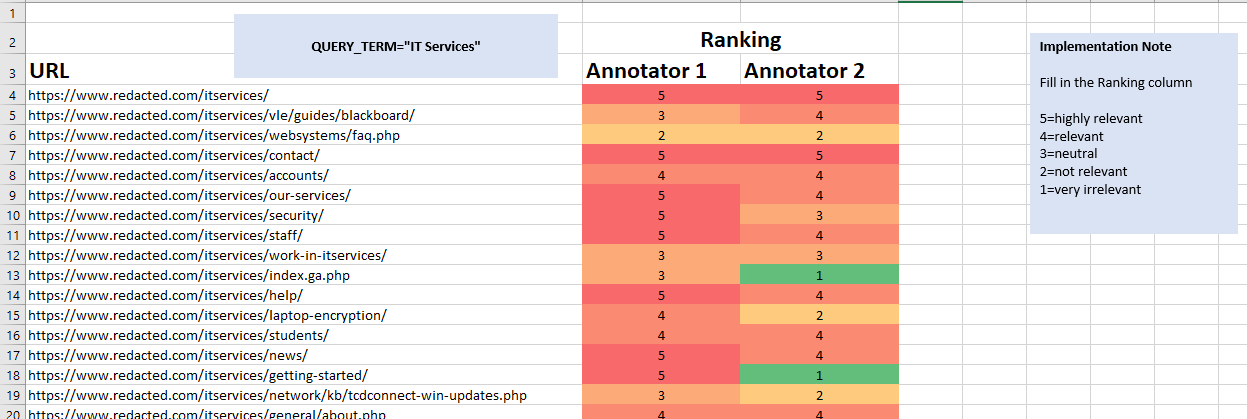


Scroll to end to see calculated scores.

In [1]:
import numpy as np 
import pandas as pd

from sklearn.metrics import cohen_kappa_score
from statsmodels.stats import inter_rater as irr



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/iaa-es/train-url-judgements-itservices-IAA-completed-v4.xlsx


In [2]:
#specify column names
#colnames = ['URL':string, 'Annotator1':int, 'Annotator2':int]

data = pd.read_excel(r'/kaggle/input/iaa-es/train-url-judgements-itservices-IAA-completed-v4.xlsx',
                     sheet_name='Sheet1',
                     usecols='A,B,C',
                     skiprows=2,
                     dtype = {'URL': str, 'Annotator 1': float, 'Annotator 2': float})

df = pd.DataFrame(data)#, columns=['URL','Annotator 1','Annotator 2'])


df['Annotator 1'] = df['Annotator 1'].astype(np.int64)
df['Annotator 2'] = df['Annotator 2'].astype(np.int64)

df.head(5)
#df.dtypes

,URL,Annotator 1,Annotator 2
0,https://www.redacted.com/itservices/,5,5
1,https://www.redacted.com/itservices/vle/guides...,3,4
2,https://www.redacted.com/itservices/websystems...,2,2
3,https://www.redacted.com/itservices/contact/,5,5
4,https://www.redacted.com/itservices/accounts/,4,4


In [3]:
rater1 = df['Annotator 1'].to_numpy()
rater2 = df['Annotator 2'].to_numpy()

In [4]:
# degug testing

# rater2[rater2 == 4] = 3  # <- replace all 4's with 3's in rater 2

# rater2 = rater1  # <- a sanity check, all coefficients should return '1'



In [5]:
print('First Array has length',len(rater1))
print('Second Array has length',len(rater2))
#print(rater1)
#print(rater2)

First Array has length 565
Second Array has length 565


In [6]:
# Krippendorff's alpha -- inter-rater reliability
# (c)2011-17 Thomas Grill (http://grrrr.org)

def nominal_metric(a, b):
    return a != b

def interval_metric(a, b):
    return (a-b)**2

def ratio_metric(a, b):
    return ((a-b)/(a+b))**2

def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    '''
    Calculate Krippendorff's alpha (inter-rater reliability):
    
    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or 
    it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to coders and columns to items
    
    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    '''
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.


In [7]:
# The following converts the rater1 and rater2 lists into a tuple of the format used by the krippendorff function

f = open("output.txt", "w")
print("("+"\'",*rater1,"'" ,"," ,"'", *rater2, "\'"+")", sep=" ", file=f)
f.close()

f = open('output.txt', 'r')
content = f.read()
data = content
f.close()

In [8]:
print (data)

(' 5 3 2 5 4 5 5 5 3 3 5 4 4 5 5 3 4 4 1 5 3 1 2 1 5 1 3 2 3 2 3 3 2 5 3 2 3 2 2 3 3 2 3 2 3 4 3 3 4 3 2 1 1 3 4 3 3 3 3 4 3 3 1 3 3 3 1 4 4 2 4 1 5 4 2 2 1 1 4 4 3 3 3 3 1 2 3 3 3 1 1 4 4 4 3 1 1 3 4 4 3 2 2 3 1 3 2 2 3 3 1 2 1 3 2 3 4 3 2 1 2 3 2 1 2 2 2 2 3 2 3 2 1 1 1 3 1 4 4 3 1 3 3 1 1 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [9]:
data = eval(data)  # converts type to 'tuple'
#print (data)
#print(type(data))   # must be tuple for function below

#  **Percentage Agreement**


* This is a basic measure of agreement between two lists.   
* It does not account for 'chance agreement'.  
* Hence, the PA score should be higer than the Cohen or krippendorff coefficients.

In [10]:
# To Calculate PA, divide the number of agreements by the total number of judgements
#  First, Subtract the elements of the two lists using a for loop
subtraction = []
for i in range(len(rater1)):
    result = rater1[i] - rater2[i]
    subtraction.append(result)
# print (subtraction)  debug

# Second, Count the number of agreements (zeros)
no_of_zeros = rater1.size - np.count_nonzero(subtraction)
print(f"PA  Number of zeros (i.e. agreements): {rater1.size - np.count_nonzero(subtraction)}")
#print(f"number of non-zero: {np.count_nonzero(subtraction)}" )   # we don't actually need this - just for debug
print(f"PA  Total number of judgements: {len(rater1)}")     # len(rater1) is the total number

# Finally, divide by total to get the PA (multiple by 100 to get percentage)
PA = (no_of_zeros/len(rater1)*100)     # 476 / 565 = 0.842
print ("PA  (Percentage Agreement): %.2f" %PA)


PA  Number of zeros (i.e. agreements): 476
PA  Total number of judgements: 565
PA  (Percentage Agreement): 84.25


"Perhaps the best advice for researchers is to calculate both percent agreement and kappa. If there is likely to be much guessing among the raters, it may make sense to use the kappa statistic, but if raters are well trained and little guessing is likely to exist, the researcher may safely rely on percent agreement to determine interrater reliability."~\cite{mchugh2012}.


#  **Cohen's Kappa**


Better than PA, as it accounts for 'chance agreement'.    
* Basic (default) form of Kappa is 'unweighted'.  Use unweighted for nominal data (apples, oranges)
* Use **linear** weights when the difference between the first and second category has the same importance as a difference between the second and third category, etc. 
* Use **quadratic** weights if the difference between the first and second category is less important than a difference between the second and third category, etc.

In [11]:
print("Cohen's Kappa Score (unweighted): %.3f" % cohen_kappa_score(rater1,rater2, weights=None))
print("Cohen's Kappa Score (Linear): %.3f" % cohen_kappa_score(rater1,rater2, weights='linear'))
print("Cohen's Kappa Score (Quadratic): %.3f" % cohen_kappa_score(rater1,rater2, weights='quadratic')) 

Cohen's Kappa Score (unweighted): 0.531
Cohen's Kappa Score (Linear): 0.626
Cohen's Kappa Score (Quadratic): 0.707


In my study, judges were asked to limit the number of '5's (highly relevant) awarded - since most end users of any ranking model will not navigate to page 2 of the Search Engine Results Page.  Hence, the quadratic weight result is the most appropriate.

#  **Fleiss's Kappa**


Whereas Cohen's Kappa is based on the two raters, Fleiss's Kappa can be used on three of more raters.  

* Fleiss Kappa should yield the same result as Cohen's Kappa where number of raters is 2.

*     < 0 Poor agreement
*     0.01 - 0.20 Slight agreement
*     0.21 - 0.40 Fair agreement
*     0.41 - 0.60 Moderate agreement
*     0.61 - 0.80 Substantial agreement
*     0.81 - 1.00 Almost perfect agreement


In [12]:
rater1_rater2 = np.stack((rater1, rater2), axis=1)
#print(con)
agg = irr.aggregate_raters(rater1_rater2) # returns a tuple (data, categories)
#agg

print("Fleiss's Kappa Score (nominal): %.3f" % irr.fleiss_kappa(agg[0], method='fleiss'))

Fleiss's Kappa Score (nominal): 0.528


#  **Krippendorff's Alpha**


Whereas Cohen's Kappa is based on the concept that the observed agreement is corrected for the agreement expected by chance. Krippendorff's alpha is based on the **observed disagreement corrected for disagreement expected by chance**

* The **nominal** version treats all disagreement equal. 
* The **ordinal** method treats neighboring disagreements less severely than disagreements over several ranks. So, if one model resulted in the prediction 1 and the other in 2, this is a higher agreement than one predicting 1 and the other 3. 
* The **ratio** variant takes the metric of the scale into account and treats close misses as almost hit. 

In [13]:

missing = '*' # indicator for missing values
array = [d.split() for d in data]  # convert to 2D list of string items
    
print("Krippendorff's Alpha Score (nominal): %.3f" % krippendorff_alpha(array, nominal_metric, missing_items=missing))
print("Krippendorff's Alpha Score (ordinal): %.3f" % krippendorff_alpha(array, interval_metric, missing_items=missing))
print("Krippendorff's Alpha Score (interval): %.3f" % krippendorff_alpha(array, ratio_metric, missing_items=missing))
    

Krippendorff's Alpha Score (nominal): 0.528
Krippendorff's Alpha Score (ordinal): 0.703
Krippendorff's Alpha Score (interval): 0.730


For Krippendorff’s coefficient, reliabilities with **α ≥ 0.667 are “acceptable for tentative conclusions”** (Krippendorff, 2018)